In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math

from skimage import *
from skimage import io, color
from skimage.measure import compare_psnr, compare_ssim

In [2]:
def multiplier(a,b,op_len):
    
    a_bi = np.binary_repr(a, width=op_len)
    b_bi = np.binary_repr(b, width=op_len)
    p1 = np.zeros((8,8),dtype=int)
    
    a1_bi = np.array([int(a_bi[0]),int(a_bi[1]),int(a_bi[2]),int(a_bi[3]),int(a_bi[4]),int(a_bi[5]),int(a_bi[6]),int(a_bi[7])])
    b1_bi = np.array([int(b_bi[0]),int(b_bi[1]),int(b_bi[2]),int(b_bi[3]),int(b_bi[4]),int(b_bi[5]),int(b_bi[6]),int(b_bi[7])])
    
    #Partial product matrix generation
    for i in range(op_len):
        for j in range(op_len):
            p1[i,j]=a1_bi[j]*b1_bi[i]
            
    p=np.flip(p1)
            
    #First stage of PP reduction from 8 to 4 in C-N configuration
    #calling half adders
    sh1,ch1 = half_adder(p[0,4],p[1,3])
    sh2,ch2 = half_adder(p[4,2],p[5,1])
    sh3,ch3 = half_adder(p[6,3],p[7,2])
    

    #calling full adders
    sf1,cf1 = full_adder(p[5,3],p[6,2],p[7,1])

    #calling approximate compressor yang1 which is used in lower 8 columns
    sy11,cy11 = yang2(p[0,5],p[1,4],p[2,3],p[3,2])
    sy12,cy12 = yang2(p[0,6],p[1,5],p[2,4],p[3,3])
    sy13,cy13 = yang2(p[0,7],p[1,6],p[2,5],p[3,4])
    sy14,cy14 = yang2(p[4,3],p[5,2],p[6,1],p[7,0])

    #calling exact compressor  which is used in higher 8 columns
    se11,ce11,tout11 = exact_compressor(p[1,7],p[2,6],p[3,5],p[4,4],0)
    se12,ce12,tout12 = exact_compressor(p[2,7],p[3,6],p[4,5],p[5,4],tout11)
    se13,ce13,tout13 = exact_compressor(p[3,7],p[4,6],p[5,5],p[6,4],tout12)

    #calling full adder which takes carry output of exact compressor 3 as its third input
    sf2,cf2 = full_adder(p[4,7],p[5,6],tout13)


    #Second stage of PP reduction from 4 to 2 in C-N configuration
   
    #calling half adders
    sh4,ch4 = half_adder(p[0,2],p[1,1])

    #calling approximate compressor yang1 which is used in lower 8 columns
    sy21,cy21 = yang2(p[0,3],p[1,2],p[2,1],p[3,0])
    sy22,cy22 = yang2(sh1,p[2,2],p[3,1],p[4,0])
    sy23,cy23 = yang2(sy11,ch1,p[4,1],p[5,0])
    sy24,cy24 = yang2(sy12,cy11,sh2,p[6,0])
    sy25,cy25 = yang2(sy13,cy12,sy14,ch2)

    #calling exact compressor  which is used in higher 8 columns
    se21,ce21,tout21 = exact_compressor(se11,cy13,sf1,cy14,0)
    se22,ce22,tout22 = exact_compressor(se12,ce11,sh3,cf1,tout21)
    se23,ce23,tout23 = exact_compressor(se13,ce12,p[7,3],ch3,tout22)
    se24,ce24,tout24 = exact_compressor(sf2,ce13,p[6,5],p[7,4],tout23)
    se25,ce25,tout25 = exact_compressor(p[5,7],cf2,p[6,6],p[7,5],tout24)

    #calling full adder which takes carry output of exact compressor 5 as its third input
    sf3,cf3 = full_adder(p[6,7],p[7,6],tout25)


    #Third stage of carry propagation addition of two final rows in C-N configuration

    #calling half adders
    sh5,ch5 = half_adder(p[0,1],p[1,0])

    #calling full adders
    sf4,cf4 = full_adder(sh4,p[2,0],ch5)
    sf5,cf5 = full_adder(sy21,ch4,cf4)
    sf6,cf6 = full_adder(sy22,cy21,cf5)
    sf7,cf7 = full_adder(sy23,cy22,cf6)
    sf8,cf8 = full_adder(sy24,cy23,cf7)
    sf9,cf9 = full_adder(sy25,cy24,cf8)
    sf10,cf10 = full_adder(se21,cy25,cf9)
    sf11,cf11 = full_adder(se22,ce21,cf10)
    sf12,cf12 = full_adder(se23,ce22,cf11)
    sf13,cf13 = full_adder(se24,ce23,cf12)
    sf14,cf14 = full_adder(se25,ce24,cf13)
    sf15,cf15 = full_adder(sf3,ce25,cf14)
    sf16,cf16 = full_adder(p[7,7],cf3,cf15)
            
    product_bin = [cf16, sf16, sf15, sf14, sf13, sf12, sf11, sf10, sf9, sf8, sf7, sf6, sf5, sf4, sh5, p[0,0]]
    #product_bin1 = product_bin[::-1]
    product_dec = int(''.join(str(x) for x in product_bin), base=2)
    
    return product_dec

def half_adder(a,b):
    sum_h = a^b
    carry_h = a&b
    
    return sum_h,carry_h

def full_adder(a,b,c):
    sum_f=(a^b)^c
    carry_f=(a & b)|(b & c)|(c & a)
    
    return sum_f,carry_f

def exact_compressor(x1,x2,x3,x4,tin):
    sum_e = ((x1^x2)^(x3^x4))^tin
    temp = (x1^x2)^x3
    carry_e = (temp & x4)|(temp & tin)|(tin & x4)  
    tout = (x1 & x2)|(x3 & x2)|(x1 & x3)
    
    return sum_e,carry_e,tout

def yang2(x1,x2,x3,x4):
    num_bi = [x4, x3, x2, x1]
    num_de = int(''.join(str(x) for x in num_bi), base=2)
    
    if num_de == 0:
        sum_a = 0
        carry_a = 0
    elif num_de == 1:
        sum_a = 1
        carry_a = 0
    elif num_de == 2:
        sum_a = 1
        carry_a = 0
    elif num_de ==3:
        sum_a = 0
        carry_a = 1
    elif num_de==4:
        sum_a = 1
        carry_a = 0
    elif num_de ==5:
        sum_a = 0
        carry_a = 1
    elif num_de ==6:
        sum_a = 0
        carry_a = 1
    elif num_de ==7:
        sum_a = 1
        carry_a = 1
    elif num_de ==8:
        sum_a = 1
        carry_a = 0
    elif num_de ==9:
        sum_a = 0
        carry_a = 1
    elif num_de ==10:
        sum_a = 0
        carry_a = 1
    elif num_de ==11:
        sum_a = 1
        carry_a = 1
    elif num_de ==12:
        sum_a = 1
        carry_a = 1
    elif num_de ==13:
        sum_a = 1
        carry_a = 1 
    elif num_de ==14:
        sum_a = 1
        carry_a = 1
    else:
        sum_a = 1
        carry_a = 1
        
    return sum_a,carry_a

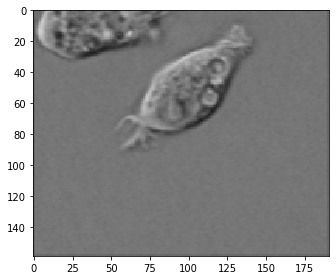

In [13]:
img = io.imread('Images/cell.tif')
output = np.zeros((img.shape[0],img.shape[1]),dtype=int)
img_pad = np.zeros((img.shape[0] + 2, img.shape[1] + 2),dtype=int)
img_pad[1:-1, 1:-1] = img
kernel = np.array([np.array([3,21,3]), np.array([21,158,21]), np.array([3,21,3])])

for x in range(img.shape[0]):
    for y in range(img.shape[1]):
        temp = img_pad[x:x+3,y:y+3]
        conv = np.zeros((3,3),dtype=int)
        
        for i in range(3):
            for j in range(3):
                conv[i,j]=multiplier(temp[i,j],kernel[i,j],8)
            
        output[x,y]=conv.sum()/256
    
output = np.uint8(output)
io.imshow(output)

In [14]:
io.imsave("/home/mallikarjun/Thesis/python/Images/check/cell_ab.tif", output)